In [2]:
# Importing some things to get rid of warnings
import os
nthreads = 1
os.environ["OMP_NUM_THREADS"] = str(nthreads) 
os.environ["OPENBLAS_NUM_THREADS"] = str(nthreads) 
os.environ["MKL_NUM_THREADS"] = str(nthreads)

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")


#%matplotlib notebook
#%matplotlib ipympl

In [3]:
# The usual suspects

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans

import SP500models as models

In [4]:
from data_pipeline.processing import sharpe_normalize, risk
from data_pipeline.processing import l2_normalization
from data_pipeline.processing import correlation_histogram
from data_pipeline.processing import market_adjust
from data_pipeline.processing import industry_adjust

To do the clustering, I made a class that keeps all of the running scores and the relevant data. This makes it easier to tune parameters down the line.

In [5]:
class KMeans_Clustering_SP500():
    def __init__(self, n_min = 2, n_max = None,  test_size = 7, use_validation = True):

        self.test_size = 7        
        self.scores = {"DaviesBouldin": [], "CalinskiHarabasz": [], "Silhouette": [], "ElMehdi" : []}
        self.labels = []
        
        self.n_min = n_min
        self.n_max = n_max+1
        
        self.val = use_validation
        
        self.clusters = []

    def magic_score(self, SH,DB,CH):
        #return ((SH+1)/2) * np.arctan(DB)/(np.pi/2) * np.exp(-CH)
        return (SH+1)/2 * (1/(DB + 1) * (CH/(CH + 1)))
        #return ((SH + 1)/2 +  + )
    # the fit function behaves almost exactly like the usual scikit learn models.

    def fit(self, data):
        self.X = data
        
        # If no maximum clusters given, use the data
        if self.n_max == None:
            self.n_max = len(self.X.columns) - 1
        
        # doing the train-test split
        if self.val == True:
            self.X_train = self.X.iloc[:-self.test_size, :]
            self.X_test = self.X.iloc[-self.test_size:, :]
        
        if self.val == False:
            self.X_train = self.X
            self.X_test = self.X

        
        # perform the kmeans fitting for each n between n_min and n_max:
        for i in range(self.n_min, self.n_max):
            #print(f"Fitting Kmeans with {i} clusters")
            kmeans = KMeans(n_clusters = i, 
                            init='k-means++', 
                            max_iter=300, 
                            n_init=10,
                            random_state=0).fit(self.X_train.T.values)
            # stores the labels of the clustering
            self.labels.append(kmeans.labels_)
            
            cluster = dict(zip(self.X_train.columns, kmeans.labels_))
            self.clusters.append(cluster)
            
            # scores the clustering
            DB_test = davies_bouldin_score(self.X_test.T.values, kmeans.labels_)
            CH_test = calinski_harabasz_score(self.X_test.T.values, kmeans.labels_)
            Sil_test = silhouette_score(self.X_test.T.values, kmeans.labels_, metric='euclidean')
            ElMehdi_test = self.magic_score(Sil_test, CH_test, DB_test)

            self.scores["DaviesBouldin"].append(DB_test)
            self.scores["CalinskiHarabasz"].append(CH_test)
            self.scores["Silhouette"].append(Sil_test)
            self.scores["ElMehdi"].append(ElMehdi_test)
        print("Finished fitting. Generating plots...")
    

    # this bit of code produces pretty pictures.
    def summarize(self, comparison = None):
        comparison_labels = list(comparison.values())

        DB_compare = davies_bouldin_score(self.X_test.values.T, 
                                          comparison_labels)
        CH_compare = calinski_harabasz_score(self.X_test.values.T, 
                                             comparison_labels)
        Sil_compare = silhouette_score(self.X_test.values.T, 
                                       comparison_labels, 
                                       metric='euclidean')
        ElMehdi_compare = self.magic_score(Sil_compare, DB_compare, CH_compare)


        f, axarr = plt.subplots(4, sharex=False, figsize = (6,6))
        f.set_figheight(12)
        f.set_figwidth(12)

        axarr[0].set_title("Comparing scores between kmeans and Industry clusters (in red)")
        axarr[3].set_xlabel("number of clusters in kmeans")

        p1 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["DaviesBouldin"], 
                          ax = axarr[0])
        p1.axhline(y = DB_compare, color = 'red')
        p1.set_ylabel("Davies Bouldin Score (low is good)")

        p2 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["CalinskiHarabasz"],
                          ax = axarr[1], 
                          legend = False)
        p2.axhline(y = CH_compare, color = 'red')
        print(f"Baseline CH score: {CH_compare}")
        p2.set_ylabel("Calinski Harabasz Score (high is good)")

        p3 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["Silhouette"], 
                          ax = axarr[2], 
                          legend = False)
        p3.axhline(y = Sil_compare, color = 'red')
        p3.set_ylabel("Silhouette Score (high is good)")

        p3 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                        y = self.scores["ElMehdi"], 
                        ax = axarr[3], 
                        legend = False)
        p3.axhline(y = ElMehdi_compare, color = 'red')
        p3.set_ylabel("El Mehdi's magical score")

        axarr[0].grid('on', which='major', axis='x' )
        axarr[1].grid('on', which='major', axis='x' )
        axarr[2].grid('on', which='major', axis='x' )
        axarr[3].grid('on', which='major', axis='x' )
        if (self.n_max - self.n_min) > 20:
            axarr[0].minorticks_on()
            axarr[1].minorticks_on()
            axarr[2].minorticks_on()
            axarr[3].minorticks_on()
            
            axarr[0].grid('on', which='minor', axis='x' )
            axarr[1].grid('on', which='minor', axis='x' )
            axarr[2].grid('on', which='minor', axis='x' )
            axarr[3].grid('on', which='minor', axis='x' )



        plt.show()

# Doing the fitting and modeling

For this kmeans, we tune two parameters that do not exist in the usual kmeans algorithm:
- smoothing: the idea is to scale down data that is far from the prediction horizon. This smoothing factor is a number between 0 and 1, and if $r_{-i}$ is the return of investment $i$ days ago, then the smoothing factor transforms the data $r_{-i} \to (smoothing)^i * r_{-i}$. In other words, it exponentially decays the effect of older days
- test_size: since we are doing a time series, all clustering metrics are measured on the validation data instead of the training data. test_size tunes this parameter. This can be toggled on or off with the use_validation argument, which is by default set to True.

In [6]:
# baseline clusters = industry
import pickle
with open('./models/industry_clusters.pkl', 'rb') as handle:
    industry_clusters = pickle.load(handle)

# Clustering returns

Finished fitting. Generating plots...
Baseline CH score: 0.2808937103526647


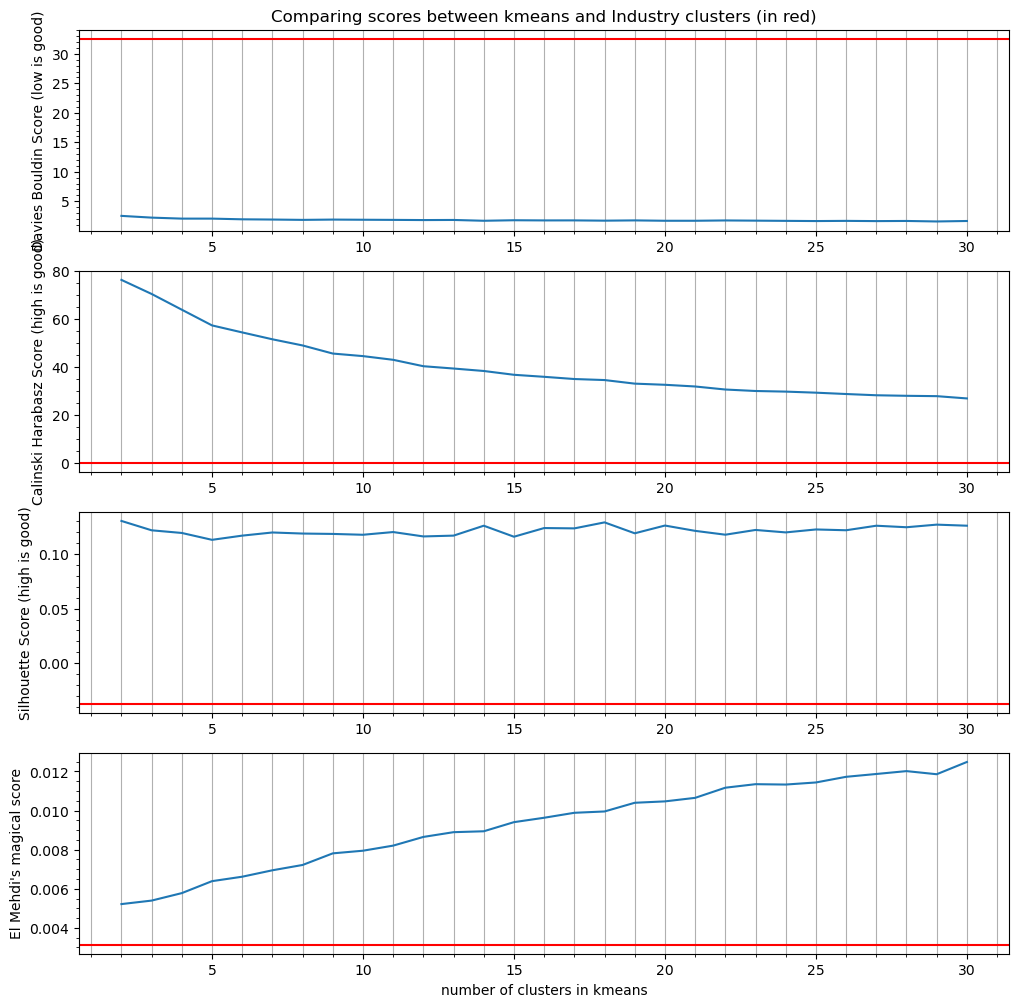

In [7]:
closing_prices = pd.read_pickle("./data/stocks/closing_prices.pkl")

closing_prices = closing_prices[::30]
ROR = closing_prices.pct_change().dropna()
ROR = industry_adjust(market_adjust(ROR), list(industry_clusters.values()))
ROR = l2_normalization(ROR)

test_size = 1
kmeansSP500 = KMeans_Clustering_SP500(n_min = 2, 
                                      n_max = 30,
                                      test_size = test_size, 
                                      use_validation = False)
kmeansSP500.fit(ROR)
kmeansSP500.summarize(industry_clusters)

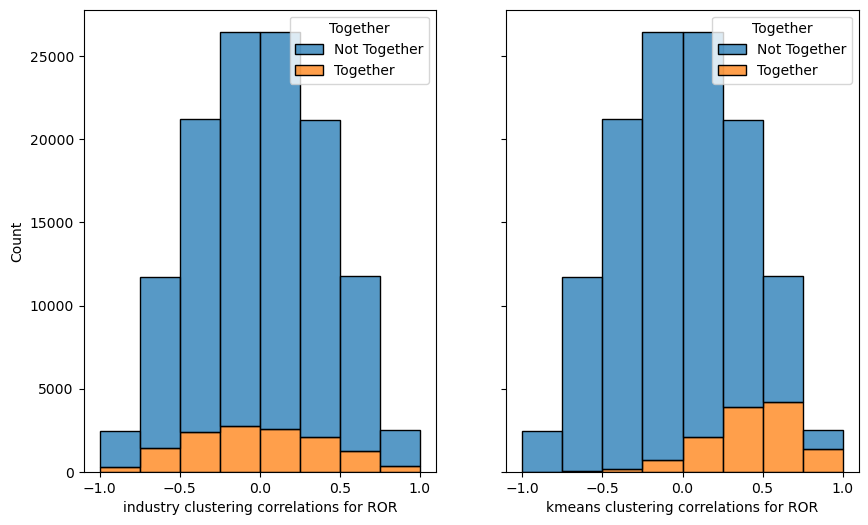

In [8]:
f, axarr = plt.subplots(1,2, sharey = True, figsize=(10,6))

axarr[0].set_xlabel("industry clustering correlations for ROR")
axarr[1].set_xlabel("kmeans clustering correlations for ROR")

correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[0])

best_cluster_ind = np.argmax(kmeansSP500.scores['CalinskiHarabasz'])
correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = kmeansSP500.clusters[8], ax = axarr[1])


<AxesSubplot:xlabel='2023-07-21 00:00:00-04:00', ylabel='2023-09-01 00:00:00-04:00'>

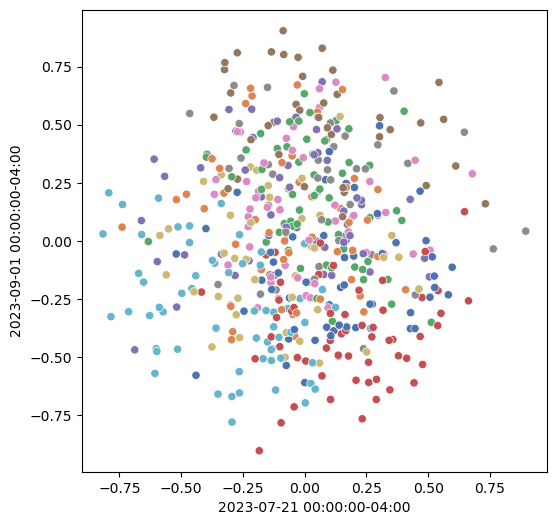

In [9]:
clusters = kmeansSP500.clusters[8]
final_prices = ROR[-3:].T
final_prices["cluster"] = list(clusters.values())
cols = final_prices.columns
f, ax = plt.subplots(figsize = (6,6))

sns.scatterplot(data = final_prices, x = cols[0], y = cols[1], hue = 'cluster', palette = 'deep', ax = ax, legend = False)

RuntimeError: Requested MovieWriter (ffmpeg) not available

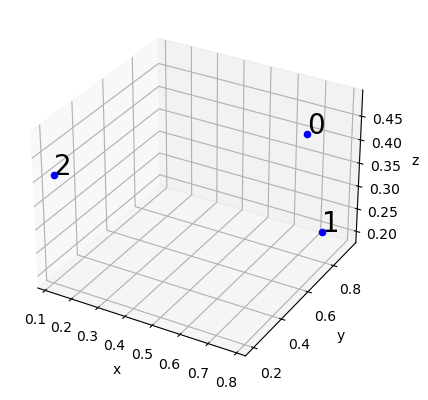

In [15]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from numpy.random import rand
from IPython.display import HTML
from matplotlib import animation

m = rand(3,3) # m is an array of (x,y,z) coordinate triplets

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(m)): # plot each point + it's index as text above
  x = m[i,0]
  y = m[i,1]
  z = m[i,2]
  label = i
  ax.scatter(x, y, z, color='b')
  ax.text(x, y, z, '%s' % (label), size=20, zorder=1, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

def animate(frame):
  ax.view_init(30, frame/4)
  plt.pause(.001)
  return fig

anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())

In [ ]:

clusters = kmeansSP500.clusters[8]
final_prices = ROR[-5:-2].T
final_prices["cluster"] = list(clusters.values())
cols = final_prices.columns

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(projection='3d')

ax.scatter(xs = final_prices[cols[0]], ys = final_prices[cols[1]], zs = final_prices[cols[2]], c = final_prices[cols[3]], cmap = "hsv")


In [11]:


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

clusters = industry_clusters
name_to_num = {name : i for (i, name) in enumerate(set(industry_clusters.values()))}
clusters = {tick : name_to_num[industry_clusters[tick]] for tick in industry_clusters.keys()}
final_prices = ROR[-5:-2].T
final_prices["cluster"] = list(clusters.values())
cols = final_prices.columns

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(projection='3d')

ax.scatter(xs = final_prices[cols[0]], ys = final_prices[cols[1]], zs = final_prices[cols[2]], c = final_prices[cols[3]], cmap = "hsv")

<IPython.core.display.Javascript object>

Fitting Kmeans with 2 clusters
Fitting Kmeans with 3 clusters
Fitting Kmeans with 4 clusters
Fitting Kmeans with 5 clusters
Fitting Kmeans with 6 clusters
Fitting Kmeans with 7 clusters
Fitting Kmeans with 8 clusters
Fitting Kmeans with 9 clusters
Fitting Kmeans with 10 clusters
Fitting Kmeans with 11 clusters
Fitting Kmeans with 12 clusters
Fitting Kmeans with 13 clusters
Fitting Kmeans with 14 clusters
Fitting Kmeans with 15 clusters
Fitting Kmeans with 16 clusters
Fitting Kmeans with 17 clusters
Fitting Kmeans with 18 clusters
Fitting Kmeans with 19 clusters
Fitting Kmeans with 20 clusters
Fitting Kmeans with 21 clusters
Fitting Kmeans with 22 clusters
Fitting Kmeans with 23 clusters
Fitting Kmeans with 24 clusters
Fitting Kmeans with 25 clusters
Fitting Kmeans with 26 clusters
Fitting Kmeans with 27 clusters
Fitting Kmeans with 28 clusters
Fitting Kmeans with 29 clusters
Fitting Kmeans with 30 clusters
Baseline CH score: 0.21900470273631284


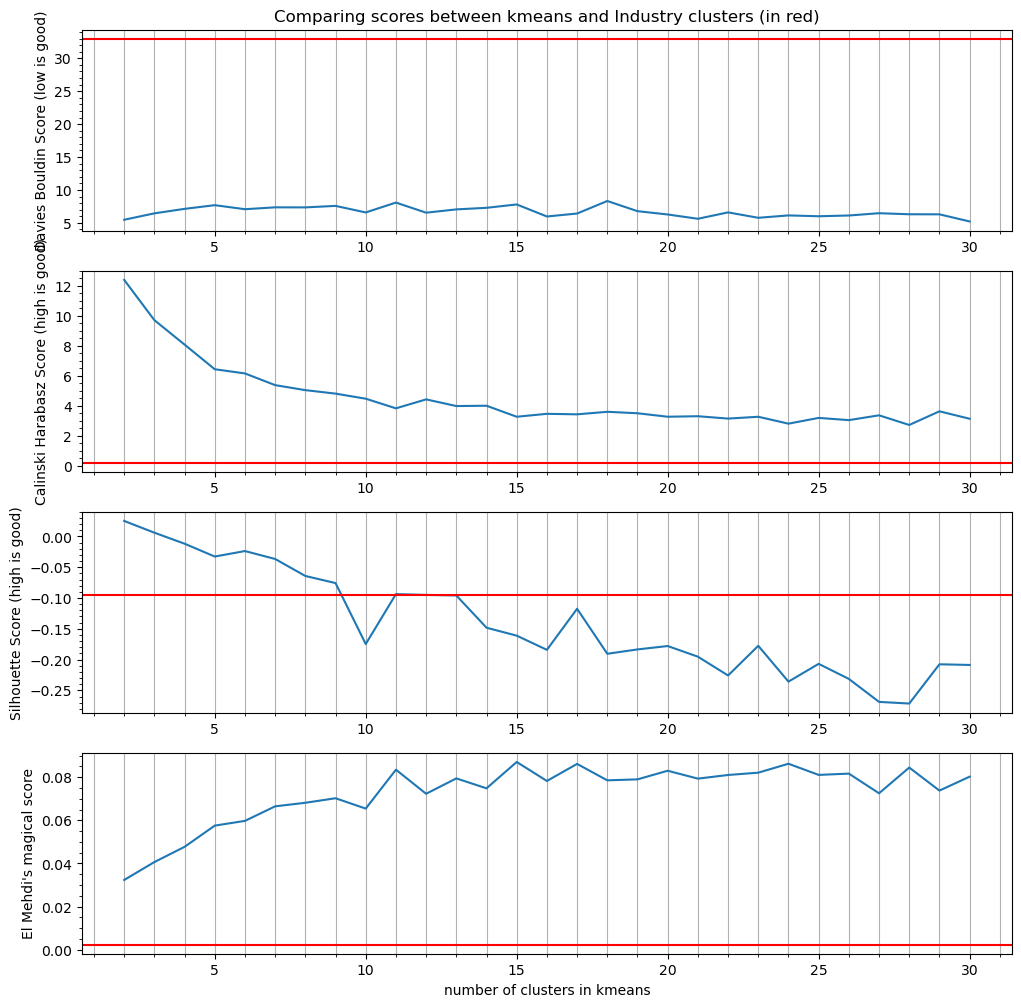

In [87]:

ROR = closing_prices.pct_change().dropna()
ROR = industry_adjust(market_adjust(ROR), list(industry_clusters.values()))
ROR = l2_normalization(ROR)
kmeansSP500_2 = KMeans_Clustering_SP500(n_min = 2, 
                                      n_max = 30,
                                      test_size = 7, 
                                      use_validation = True)
kmeansSP500_2.fit(ROR)
kmeansSP500_2.summarize(industry_clusters)


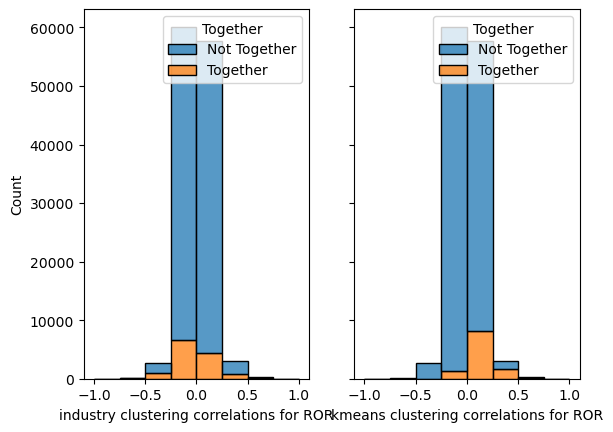

In [88]:
f, axarr = plt.subplots(1,2, sharey = True)

axarr[0].set_xlabel("industry clustering correlations for ROR")
axarr[1].set_xlabel("kmeans clustering correlations for ROR")

correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[0])

best_cluster_ind = np.argmax(kmeansSP500_2.scores['CalinskiHarabasz'])
correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = kmeansSP500_2.clusters[11], ax = axarr[1])

In [89]:
np.argmax(kmeansSP500_2.scores['CalinskiHarabasz'])

0

In [90]:
np.mean([np.sum(np.random.rand(3)) for _ in range(10000)])

1.5066788196124064

As we can see, Kmeans on its own cannot beat the baseline model of industry clustering for risk-adjusted returns, which are the most useful for financial modeling.

There are two possible alternate approaches. 
- The first is to cluster *within* each industry cluster, and to refine the industry clustering. 
- The second is to try to remove the influence of "industry" on the sharpe rates of return, and then to try clustering again.